In [47]:
from __future__ import print_function, division

import numpy as np
import tensorflow as tf
import keras


from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Input, Lambda
from keras.optimizers import RMSprop
from pathlib import Path
import imageio
%matplotlib inline
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
from scipy import ndimage
from matplotlib.colors import ListedColormap
from skimage.feature import peak_local_max
from skimage import measure
import os
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
import random
import os
import sys
import random
import warnings
from tqdm import tqdm


import pandas as pd

from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.layers.core import  Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_PATH = 'SampleTraining/sample_train/'
# TEST_PATH = '../Machinelearning/assignment2/stage1_test/'

seed = int(500)


# Get images

In [49]:
train_ids = next(os.walk(TRAIN_PATH))[1]

In [50]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|██████████| 100/100 [00:15<00:00,  6.53it/s]


# Metric

In [48]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [9]:
X_train = X_train/255

# MLP, pixel classification for each image

In [45]:
# reshape to do classification by pixel 
from keras import optimizers
Xx_train = X_train.reshape(100, 256*256, 3) #images
Yy_train = Y_train.reshape(100, 256*256, 1) #masks

mlp = Sequential()

mlp.add(Dense(512, activation='relu', input_shape = (256*256,3), bias = True))
mlp.add(Dropout(0.3))
mlp.add(Dense(256, activation='relu', bias = True))
mlp.add(Dropout(0.3))
mlp.add(Dense(1, activation='sigmoid')) 

adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mlp.compile(loss='binary_crossentropy',
            optimizer=adam,
            metrics = [mean_iou])
mlp.summary()
# mlp.fit(Xx_train, Yy_train,
#         batch_size=16, 
#         epochs=2,
#         verbose=1,
#         validation_split=0.1,)

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_shape=(65536, 3), activation="relu", use_bias=True)`
  
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, activation="relu", use_bias=True)`
  # Remove the CWD from sys.path while we load stuff.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 65536, 512)        2048      
_________________________________________________________________
dropout_11 (Dropout)         (None, 65536, 512)        0         
_________________________________________________________________
dense_16 (Dense)             (None, 65536, 256)        131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 65536, 256)        0         
_________________________________________________________________
dense_17 (Dense)             (None, 65536, 1)          257       
Total params: 133,633
Trainable params: 133,633
Non-trainable params: 0
_________________________________________________________________


In [36]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('modellearningrate.h5', verbose=1, save_best_only=True)
results = mlp.fit(Xx_train, Yy_train, validation_split=0.1, batch_size=16, epochs=20)

Train on 90 samples, validate on 10 samples
Epoch 1/20
90/90 [==============================] - 120s 1s/step - loss: 4.4008 - mean_iou: 0.2933 - val_loss: 0.7118 - val_mean_iou: 0.2691
Epoch 2/20
90/90 [==============================] - 119s 1s/step - loss: 0.6490 - mean_iou: 0.1880 - val_loss: 0.6200 - val_mean_iou: 0.1356
Epoch 3/20
90/90 [==============================] - 117s 1s/step - loss: 0.6064 - mean_iou: 0.1101 - val_loss: 0.5818 - val_mean_iou: 0.0906
Epoch 4/20
90/90 [==============================] - 115s 1s/step - loss: 0.5620 - mean_iou: 0.0787 - val_loss: 0.4698 - val_mean_iou: 0.0681
Epoch 5/20
90/90 [==============================] - 117s 1s/step - loss: 0.4313 - mean_iou: 0.0614 - val_loss: 0.3377 - val_mean_iou: 0.0545
Epoch 6/20
90/90 [==============================] - 126s 1s/step - loss: 0.3438 - mean_iou: 0.0499 - val_loss: 0.3982 - val_mean_iou: 0.0454
Epoch 7/20
90/90 [==============================] - 116s 1s/step - loss: 0.3441 - mean_iou: 0.0422 - val_loss:

KeyboardInterrupt: 

In [9]:
def plotKerasLearningCurve(filename):
    plt.figure(figsize=(10,5))
    metrics = np.load(filename)[()]
    filt = ['mean_iou'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean iou')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
plot_learning_curve(results)
plt.show()


NameError: name 'results' is not defined

In [14]:
preds_train = preds_train.reshape(90,256,256,1)
preds_val = preds_val.reshape(10, 256, 256, 1)

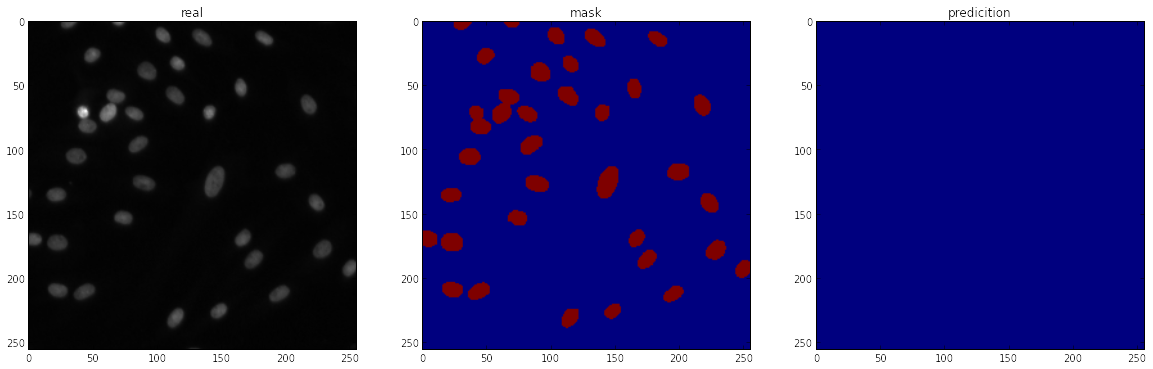

In [15]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_train))

plt.subplot(1,3,1)
plt.imshow(X_train[ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_train[ix]>0.5))
plt.title('predicition')

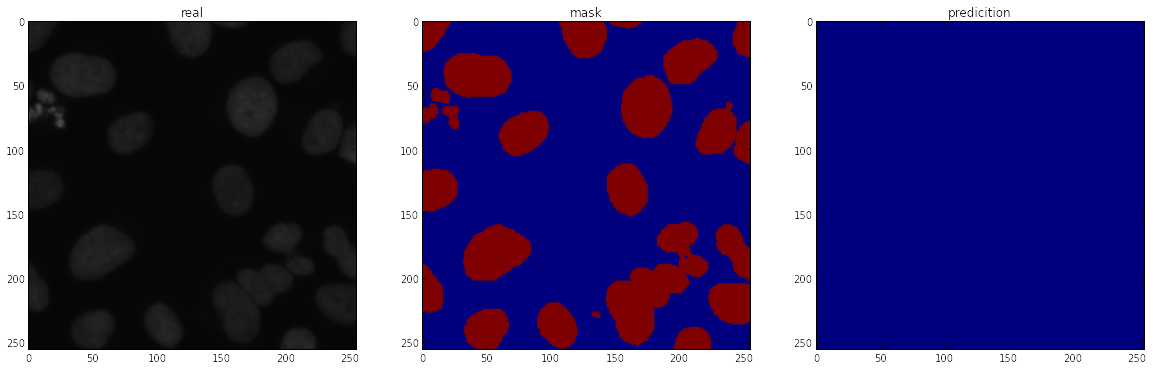

In [24]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_val))
# ix = 0
plt.subplot(1,3,1)
plt.imshow(X_train[90 + ix])
plt.title('real')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_train[90 +ix]))
plt.title('mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(preds_val[ix]>0.5))
plt.title('predicition')

# Split each image into 256 subimages on sample training

In [21]:
cut_im = np.zeros((len(train_ids), 256, 16, 16, 3), dtype=np.uint8)
cut_masks = np.zeros((len(train_ids),256, 16, 16, 1), dtype = np.bool)

for index, im in enumerate(X_train):
    sub_im = np.zeros((256, 16, 16, 3), dtype = np.uint8)
    sub_mask = np.zeros((256, 16, 16, 1), dtype = np.bool)
    count = 0
    for i in range(16):
        for j in range(16):
            new_im = X_train[index][16*i:16*(i+1), 16*j:16*(j+1)]
            new_mask = Y_train[index][16*i: 16*(i+1), 16*j:16*(j+1)]
            sub_im[count] = new_im
            sub_mask[count] = new_mask
            count +=1
    
    cut_im[index] = sub_im
    cut_masks[index] = sub_mask



In [6]:
pixels_im = cut_im.reshape(100,256,256,3) # image 1, first cutting (out of 256)
pixels_masks = cut_masks.reshape(100, 256,256,1) # 100 images, with 256 subimages that flatten so size 16*16

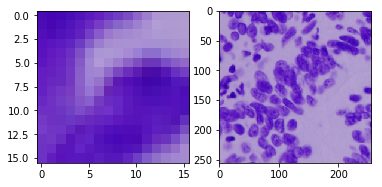

In [28]:
plt.subplot(1,2,1)
plt.imshow(cut_im[12][9])
plt.subplot(1,2,2)
plt.imshow(X_train[12])
# plt.imshow(np.squeeze(Y_train[0]))

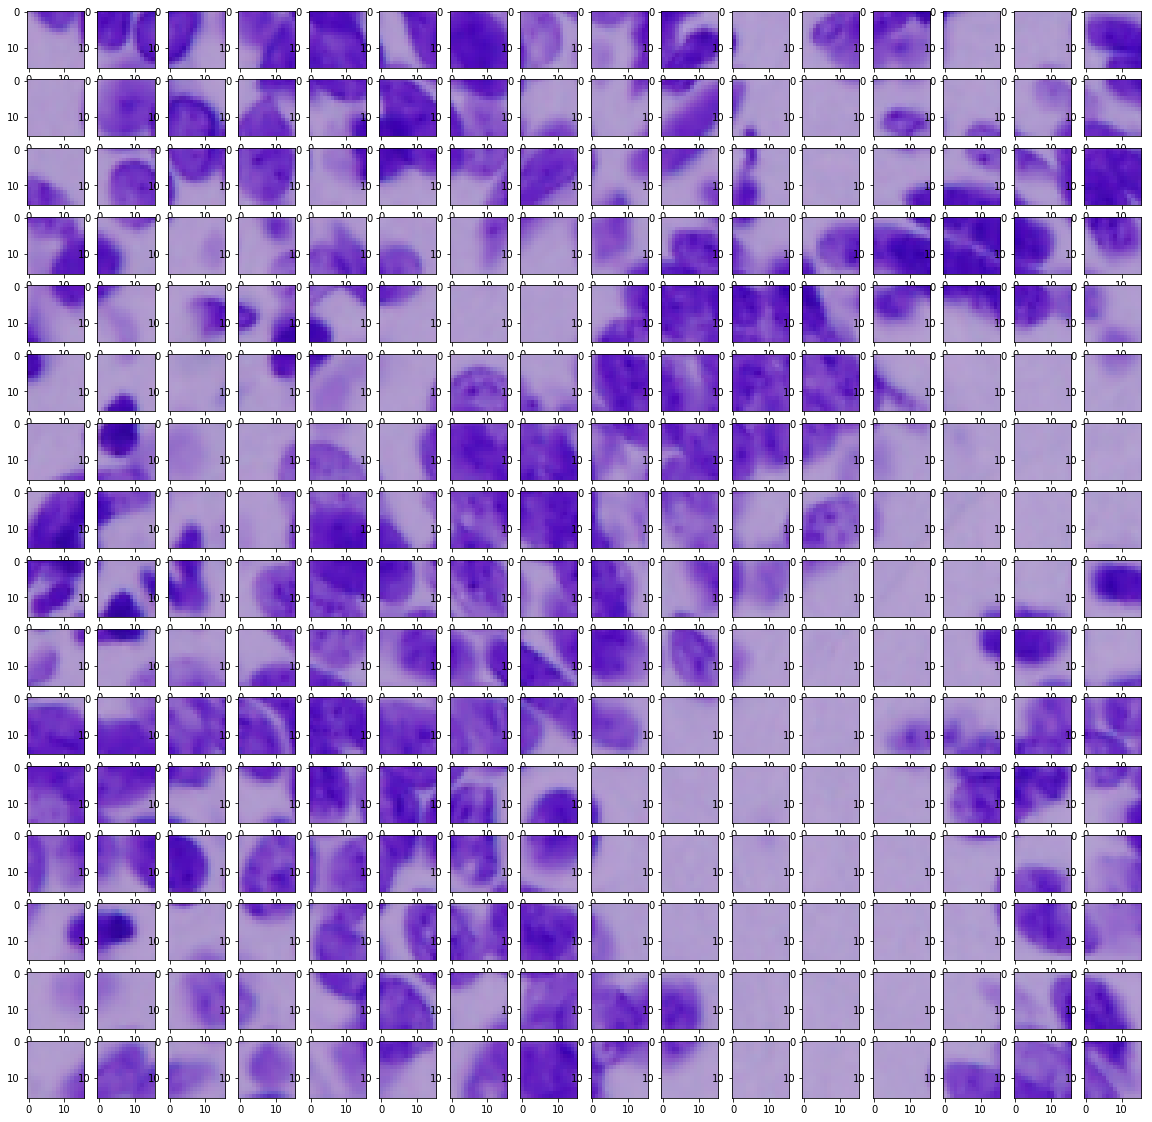

In [29]:
plt.figure(figsize= (20,20))
for i in range(256):
    plt.subplot(16,16, i+1)
    plt.imshow(cut_im[12][i])

In [98]:
pred_image = np.zeros((100, 256, 256, 1), dtype = np.bool)
for m in range(len(pixels_masks)):
    reshap = []
    for image in pixels_masks[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1), dtype = np.bool)
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image[m] = Final_im

# print(reshap)
# plt.imshow(np.squeeze(reshap[15]))

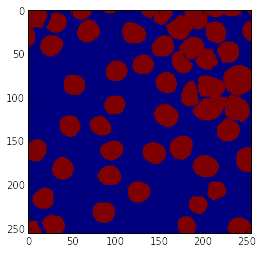

In [99]:
plt.imshow(np.squeeze(pred_image[0]))

# predictions for each

In [8]:
# Xx_train = X_train.reshape(100, 256*256, 3) #images
# Yy_train = Y_train.reshape(100, 256*256, 1) #masks

mlpFE = Sequential()

mlpFE.add(Dense(128, activation='relu', input_shape = (256, 256,3), bias = True))
mlpFE.add(Dropout(0.2))
mlpFE.add(Dense(128, activation='relu', bias = True))
mlpFE.add(Dropout(0.2))
mlpFE.add(Dense(1, activation='sigmoid')) 

mlpFE.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics = [mean_iou])
mlpFE.summary()

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", input_shape=(256, 256,..., use_bias=True)`
  
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", use_bias=True)`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256, 256, 128)     512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 256, 256, 128)     0         
_________________________________________________________________
dense_2 (Dense)              (None, 256, 256, 128)     16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 256, 256, 128)     0         
_________________________________________________________________
dense_3 (Dense)              (None, 256, 256, 1)       129       
Total params: 17,153
Trainable params: 17,153
Non-trainable params: 0
_________________________________________________________________


In [9]:
# from keras.callbacks import EarlyStopping, ModelCheckpoint
# earlystopper = EarlyStopping(patience=5, verbose=1)
# checkpointer = ModelCheckpoint('model-dsbowl2018-mlptraining.h5', verbose=1, save_best_only=True)
results = mlpFE.fit(pixels_im, pixels_masks, validation_split=0.1, batch_size=16, epochs=20)

Train on 90 samples, validate on 10 samples
Epoch 1/20
90/90 [==============================] - 30s 335ms/step - loss: 1.5992 - mean_iou: 0.1561 - val_loss: 1.7011 - val_mean_iou: 0.0967
Epoch 2/20
90/90 [==============================] - 29s 319ms/step - loss: 1.4242 - mean_iou: 0.0814 - val_loss: 0.8515 - val_mean_iou: 0.0934
Epoch 3/20
90/90 [==============================] - 29s 323ms/step - loss: 1.2870 - mean_iou: 0.0941 - val_loss: 0.8986 - val_mean_iou: 0.0914
Epoch 4/20
90/90 [==============================] - 29s 322ms/step - loss: 1.1602 - mean_iou: 0.0956 - val_loss: 0.8117 - val_mean_iou: 0.0950
Epoch 5/20
90/90 [==============================] - 29s 323ms/step - loss: 1.0849 - mean_iou: 0.0988 - val_loss: 0.9344 - val_mean_iou: 0.1011
Epoch 6/20
90/90 [==============================] - 31s 340ms/step - loss: 1.0157 - mean_iou: 0.1030 - val_loss: 0.7171 - val_mean_iou: 0.1016
Epoch 7/20
90/90 [==============================] - 29s 323ms/step - loss: 0.9623 - mean_iou: 0.10

In [10]:
preds_trainFE = mlpFE.predict(pixels_im[:int(pixels_im.shape[0]*0.9)], verbose=1)
preds_valFE = mlpFE.predict(pixels_im[int(pixels_im.shape[0]*0.9):], verbose=1)
# pred_t = (preds_trainFE >0.5).astype(np.uint8)
# preds_train = preds_train.reshape(90,256,256,1)
# preds_val = preds_val.reshape(10, 256, 256, 1)
# print(sum(pred_t))

10/10 [==============================] - 1s 54ms/step


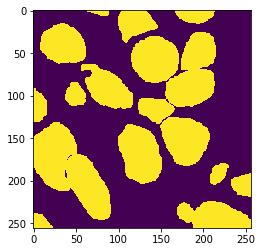

In [13]:
plt.imshow(np.squeeze(Y_train[97]))

In [11]:
predictive_masks = []
pred_image_train = np.zeros((len(preds_valFE), 256, 256, 1))
for m in range(len(preds_valFE)):
    reshap = []
    for image in preds_valFE[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_train[m] = Final_im

for ind, images in enumerate(pred_image_train):
    thresh = threshold_otsu(pred_image_train[ind])
    great = np.where(pred_image_train[ind]>thresh)
    less = np.where(pred_image_train[ind]<thresh)
    if (sum(pred_image_train[ind][great])< sum(pred_image_train[ind][less])):
        pred_image_train[ind][less] = 0
        pred_image_train[ind][great] = 1
    else:
        pred_image_train[ind][great] = 0
        pred_image_train[ind][less] = 1
    predictive_masks.append(pred_image_train[ind])

# Testing data and RLE

In [58]:
TRAINING_PATH = 'stage1_train/'
TESTING_PATH = 'stage1_test/'

In [60]:
X_test = np.zeros((len(testing_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
size_test_height_te = []
size_test_width_te = []
size_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(testing_ids), total=len(testing_ids)):
    path = TESTING_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    size_test_height_te.append(img.shape[0])
    size_test_width_te.append(img.shape[1])
    size_test.append(img.shape)
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

Getting and resizing test images ... 


100%|██████████| 65/65 [00:00<00:00, 65.71it/s]


In [59]:
training_ids = next(os.walk(TRAINING_PATH))[1]
testing_ids = next(os.walk(TESTING_PATH))[1]

# Distribution of image size

Text(0,0.5,'Frequency')

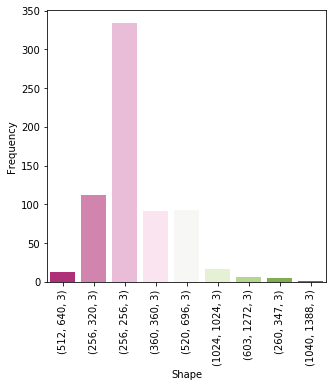

In [106]:
import seaborn as sns
plt.figure(figsize = (5,5))
df4 = pd.DataFrame()
df4['Shape'] = Shap
df4['frequency'] = fre
sns.countplot(x="Shape", data=df3, palette="PiYG")
plt.xticks(x='Shape',rotation='vertical')
plt.ylabel('Frequency')

In [9]:
cuting_im = np.zeros((len(training_ids), 256, 16, 16, 3), dtype=np.uint8)
cuting_masks = np.zeros((len(training_ids),256, 16, 16, 1), dtype = np.bool)

for index, im in enumerate(X_training):
    sub_image = np.zeros((256, 16, 16, 3), dtype = np.uint8)
    sub_masks = np.zeros((256, 16, 16, 1), dtype = np.bool)
    counts = 0
    for i in range(16):
        for j in range(16):
            new_image = X_training[index][16*i:16*(i+1), 16*j:16*(j+1)]
            new_masks = Y_training[index][16*i: 16*(i+1), 16*j:16*(j+1)]
            sub_image[counts] = new_image
            sub_masks[counts] = new_masks
            counts +=1
    
    cuting_im[index] = sub_image
    cuting_masks[index] = sub_masks

In [10]:
pixels_image = cuting_im.reshape(len(training_ids),256,256,3) # image 1, first cutting (out of 256)
pixels_mask = cuting_masks.reshape(len(training_ids), 256,256,1) # 100 images, with 256 subimages that flatten so size 16*16

### check things work

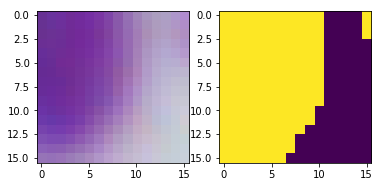

In [11]:
plt.subplot(1,2,1)
plt.imshow(cuting_im[1][10])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(cuting_masks[1][10]))

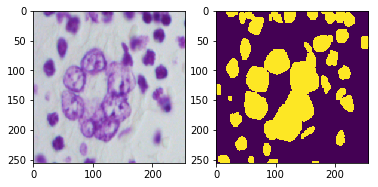

In [12]:
plt.subplot(1,2,1)
plt.imshow(X_training[1])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(Y_training[1]))

## MLP

In [46]:
mlpFE2 = Sequential()

mlpFE2.add(Dense(256, activation='relu', input_shape = (256, 256,3), bias = True))
mlpFE2.add(Dropout(0.25))
mlpFE2.add(Dense(128, activation='relu', bias = True))
mlpFE2.add(Dropout(0.25))
mlpFE2.add(Dense(1, activation='sigmoid')) 


mlpFE2.compile(loss='binary_crossentropy',
            optimizer="adam",
            metrics = [mean_iou])
mlpFE2.summary()


# Xx_training = X_training.reshape(len(X_training), 256*256, 3) #images
# Yy_training = Y_training.reshape(len(Y_training), 256*256, 1) #masks

# mlp2 = Sequential()

# mlp2.add(Dense(512, activation='relu', input_shape = (256*256,3)))
# mlp2.add(Dropout(0.2))
# mlp2.add(Dense(256, activation='relu'))
# mlp2.add(Dropout(0.2))
# mlp2.add(Dense(1, activation='sigmoid')) 

# mlp2.compile(loss='binary_crossentropy',
#             optimizer="adam",
#             metrics = [mean_iou])

/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(256, input_shape=(256, 256,..., activation="relu", use_bias=True)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/emma/.local/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(128, activation="relu", use_bias=True)`
  """


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 256, 256, 256)     1024      
_________________________________________________________________
dropout_13 (Dropout)         (None, 256, 256, 256)     0         
_________________________________________________________________
dense_19 (Dense)             (None, 256, 256, 128)     32896     
_________________________________________________________________
dropout_14 (Dropout)         (None, 256, 256, 128)     0         
_________________________________________________________________
dense_20 (Dense)             (None, 256, 256, 1)       129       
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
lr_finder = LRFinder(mlpFE2)
lr_finder.find(pixels_image, pixels_mask, start_lr=0.0001, end_lr=1, batch_size=16, epochs=5)

Epoch 1/5
670/670 [==============================] - 382s 570ms/step - loss: 1.6633 - mean_iou: 0.1711
Epoch 2/5
670/670 [==============================] - 376s 561ms/step - loss: 1.0888 - mean_iou: 0.0982
Epoch 3/5
670/670 [==============================] - 376s 561ms/step - loss: 0.4274 - mean_iou: 0.0908
Epoch 4/5
670/670 [==============================] - 372s 555ms/step - loss: 0.3700 - mean_iou: 0.0813
Epoch 5/5
160/670 [======>.......................] - ETA: 4:40 - loss: 0.4694 - mean_iou: 0.0757

# Plot of learning rates

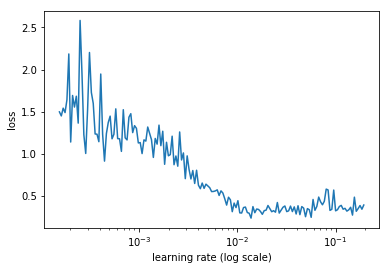

In [44]:
lr_finder.plot_loss()

In [27]:
lr_finder1 = LRFinder1(mlpFE2)
# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder1.find(pixels_image, pixels_mask, start_lr=0.0001, end_lr=1, batch_size=16, epochs=5)

Epoch 1/5
670/670 [==============================] - 378s 564ms/step - loss: 1.6853 - mean_iou: 0.0812
Epoch 2/5
670/670 [==============================] - 384s 573ms/step - loss: 0.9380 - mean_iou: 0.0798
Epoch 3/5
670/670 [==============================] - 371s 553ms/step - loss: 0.4314 - mean_iou: 0.0798
Epoch 4/5
670/670 [==============================] - 373s 557ms/step - loss: 0.4450 - mean_iou: 0.0772
Epoch 5/5
670/670 [==============================] - 370s 552ms/step - loss: 1.1012 - mean_iou: 0.0699


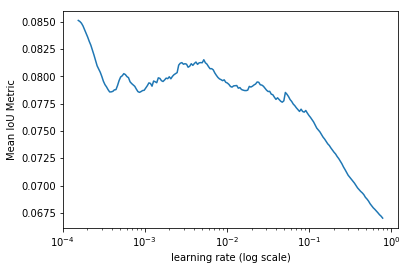

In [28]:
lr_finder1.plot_loss()

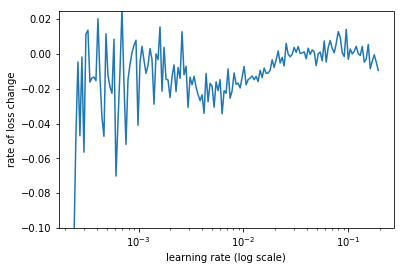

In [30]:
lr_finder.plot_loss_change(sma=20, n_skip_beginning=20, n_skip_end=5, y_lim=(-0.1, 0.025))

In [13]:

from keras.callbacks import EarlyStopping, ModelCheckpoint
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mlp_subimage_testing2.h5', verbose=1, save_best_only=True)
results = mlpFE2.fit(pixels_image, pixels_mask, validation_split=0.1, batch_size=16, epochs=20,callbacks=[earlystopper, checkpointer] )

Train on 603 samples, validate on 67 samples
Epoch 1/20
603/603 [==============================] - 437s 725ms/step - loss: 0.9273 - mean_iou: 0.0880 - val_loss: 0.5878 - val_mean_iou: 0.0781

Epoch 00001: val_loss improved from inf to 0.58779, saving model to model-dsbowl2018-mlp_subimage_testing2.h5
Epoch 2/20
603/603 [==============================] - 437s 725ms/step - loss: 0.5689 - mean_iou: 0.0736 - val_loss: 0.5119 - val_mean_iou: 0.0712

Epoch 00002: val_loss improved from 0.58779 to 0.51190, saving model to model-dsbowl2018-mlp_subimage_testing2.h5
Epoch 3/20
603/603 [==============================] - 439s 728ms/step - loss: 0.4464 - mean_iou: 0.0703 - val_loss: 0.4057 - val_mean_iou: 0.0700

Epoch 00003: val_loss improved from 0.51190 to 0.40565, saving model to model-dsbowl2018-mlp_subimage_testing2.h5
Epoch 4/20
603/603 [==============================] - 437s 724ms/step - loss: 0.3378 - mean_iou: 0.0707 - val_loss: 0.3314 - val_mean_iou: 0.0697

Epoch 00004: val_loss improve

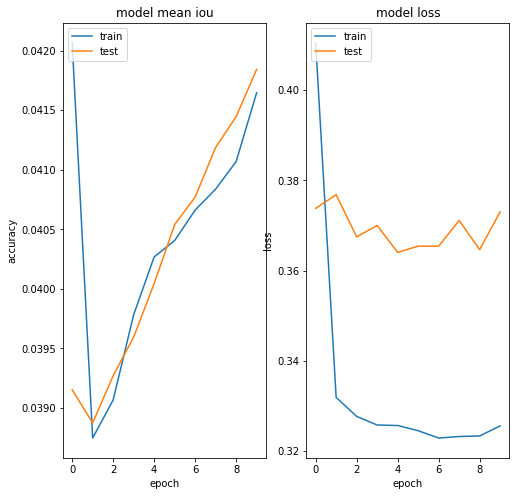

OSError: Failed to interpret file 'model-dsbowl2018-mlp_subimage_testing2.h5' as a pickle

In [100]:
def plotKerasLearningCurve(filename):
    plt.figure(figsize=(10,5))
    metrics = np.load(filename)[()]
    filt = ['mean_iou'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean iou')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
plot_learning_curve(results)
plt.show()
plotKerasLearningCurve('model-dsbowl2018-mlp_subimage_testing2.h5')
plt.show()

# Predictions

In [61]:
# X_test1 = X_test.reshape(len(X_test), 256*256, 3)
cuting_testim = np.zeros((len(testing_ids), 256, 16, 16, 3), dtype=np.uint8)
# cuting_masks = np.zeros((len(training_ids),256, 16, 16, 1), dtype = np.bool)

for index, im in enumerate(X_test):
    sub_testimage = np.zeros((256, 16, 16, 3), dtype = np.uint8)
    counts = 0
    for i in range(16):
        for j in range(16):
            new_testimage = X_test[index][16*i:16*(i+1), 16*j:16*(j+1)]
#             new_masks = Y_training[index][16*i: 16*(i+1), 16*j:16*(j+1)]
            sub_testimage[counts] = new_testimage
#             sub_masks[counts] = new_masks
            counts +=1
    
    cuting_testim[index] = sub_testimage
#     cuting_masks[index] = sub_masks

In [62]:
pixels_testimage = cuting_testim.reshape(len(testing_ids),256,256,3)

In [63]:
model_FE = load_model('model-dsbowl2018-mlp_subimage_test.h5', custom_objects={'mean_iou': mean_iou})

# preds_trainFE = mFE.predict(pixels_image[:int(pixels_image.shape[0]*0.9)], verbose=1)
# preds_valFE = mlpFE.predict(pixels_im[int(pixels_im.shape[0]*0.9):], verbose=1)
# preds_trainingFE = model_FE.predict(pixels_image[:int(pixels_image.shape[0]*0.9)], verbose=1)
# preds_training = preds_training.reshape(603, 256, 256, 1)

# preds_validFE = model_FE.predict(pixels_image[int(pixels_image.shape[0]*0.9):], verbose=1)
# preds_valid = preds_valid.reshape(67, 256, 256, 1)

preds_testFE = model_FE.predict(pixels_testimage, verbose=1)
# preds_test = preds_test.reshape(len(X_test1), 256, 256, 1)

65/65 [==============================] - 4s 60ms/step


In [55]:
predictive_trainingmasks = []
pred_image_train = np.zeros((len(preds_trainingFE), 256, 256, 1))
for m in range(len(preds_trainingFE)):
    reshap = []
    for image in preds_trainingFE[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_train[m] = Final_im

for ind, images in enumerate(pred_image_train):
    thresh = threshold_otsu(pred_image_train[ind])
    great = np.where(pred_image_train[ind]>thresh)
    less = np.where(pred_image_train[ind]<thresh)
    if (sum(pred_image_train[ind][great])> sum(pred_image_train[ind][less])):
        pred_image_train[ind][less] = 0
        pred_image_train[ind][great] = 1
    else:
        pred_image_train[ind][great] = 0
        pred_image_train[ind][less] = 1
    predictive_trainingmasks.append(pred_image_train[ind])

NameError: name 'preds_trainingFE' is not defined

In [20]:
predictive_valmasks = []
pred_image_val = np.zeros((len(preds_validFE), 256, 256, 1))
for m in range(len(preds_validFE)):
    reshap = []
    for image in preds_validFE[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_val[m] = Final_im

for ind, images in enumerate(pred_image_val):
    thresh = threshold_otsu(pred_image_val[ind])
    great = np.where(pred_image_val[ind]>thresh)
    less = np.where(pred_image_val[ind]<thresh)
    if (sum(pred_image_val[ind][great])> sum(pred_image_val[ind][less])):
        pred_image_val[ind][less] = 0
        pred_image_val[ind][great] = 1
    else:
        pred_image_val[ind][great] = 0
        pred_image_val[ind][less] = 1
    predictive_valmasks.append(pred_image_val[ind])

In [64]:
predictive_testmasks = []
pred_image_test = np.zeros((len(preds_testFE), 256, 256, 1))
for m in range(len(preds_testFE)):
    reshap = []
    for image in preds_testFE[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_test[m] = Final_im


In [99]:
# pred_test_sub = (preds_test < 0.5).astype(np.uint8)
preds_test_upsampled = []
for i in range(len(pred_image_test)):
    preds_test_upsampled.append(resize(np.squeeze(pred_image_test[i]>0.5), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

In [100]:
len(preds_test_upsampled)

65

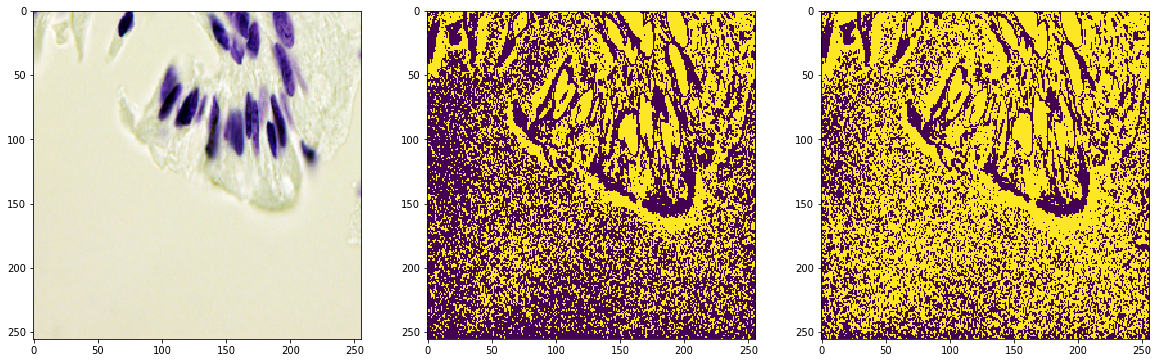

In [91]:
ix = random.randint(0, len(pred_image_test))
# ix = 23
plt.figure(figsize = (20,20))
plt.subplot(1,3,1)
plt.imshow(X_test[ix])
plt.subplot(1,3,2)
plt.imshow(np.squeeze(pred_image_test[ix]>0.5))
plt.subplot(1,3,3)
plt.imshow(np.squeeze(pred_image_test[ix]>threshold_otsu(pred_image_test[ix])))

# plot the validation 

Text(0.5,1,'Predicted Mask')

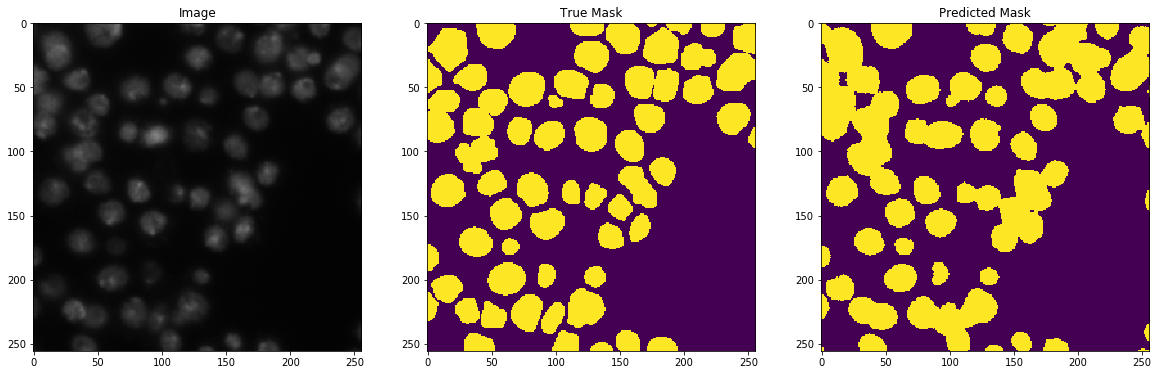

In [24]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(predictive_trainingmasks))

plt.subplot(1,3,1)
plt.imshow(X_training[ix])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predictive_trainingmasks[ix]))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

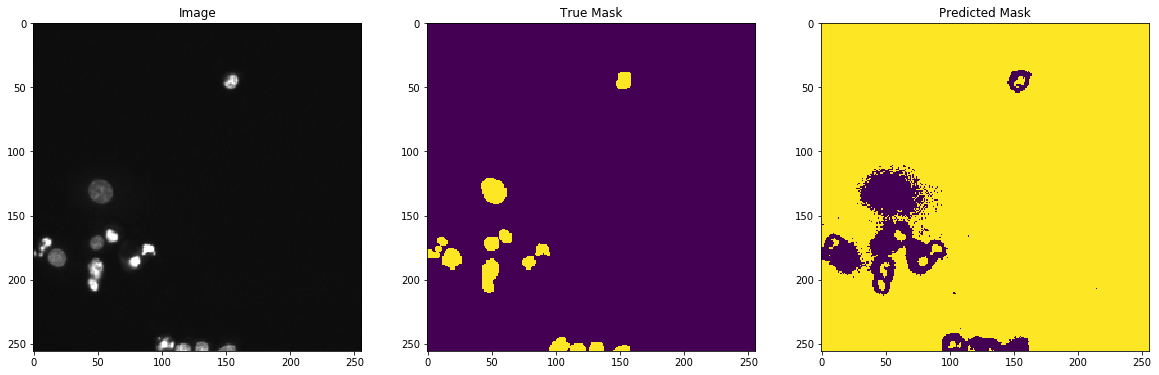

In [25]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(predictive_valmasks))

plt.subplot(1,3,1)
plt.imshow(X_training[ix+603])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix+603]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predictive_valmasks[ix]))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

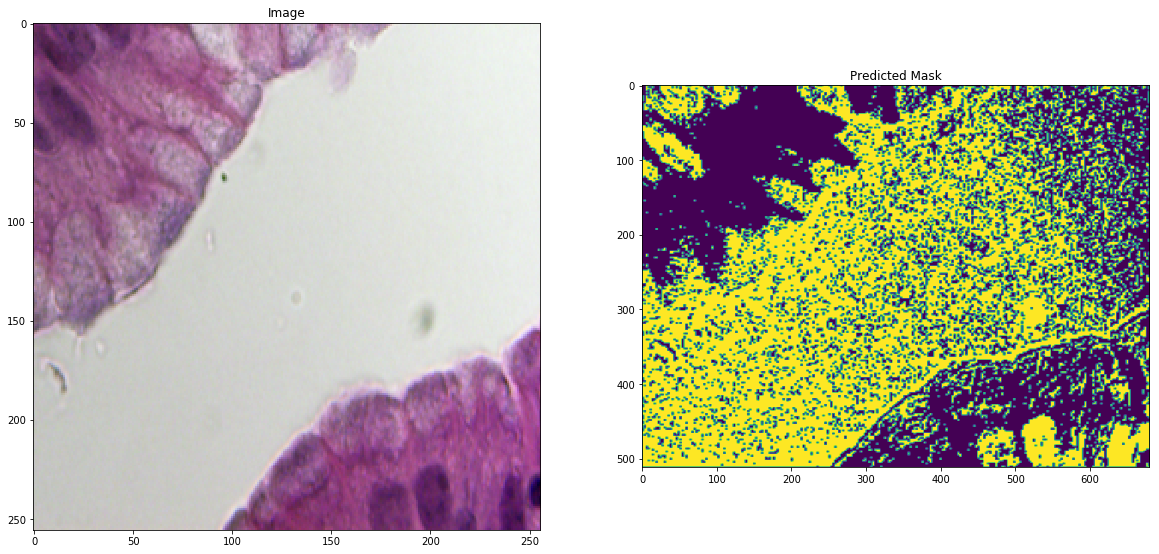

In [26]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(predictive_testmasks))

plt.subplot(1,2,1)
plt.imshow(X_test[ix])
plt.title('Image')
plt.subplot(1,2,2)
plt.imshow(preds_test_upsampled[ix])
plt.title('Predicted Mask')

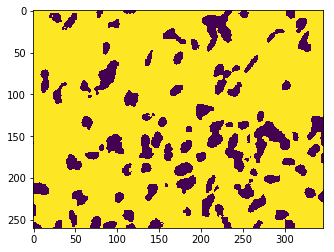

In [307]:
plt.imshow(preds_test_upsampled[ix]>0.5)
# print(preds_test_upsampled[ix])

In [92]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)


In [101]:
new_test_ids = []
rles = []
for n, id_ in enumerate(testing_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [102]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('mlpsubimagesbuthalf.csv', index=False)

# Image Augmentation

In [31]:
from skimage.util import random_noise
nb_aug = 500
augmented = np.zeros((nb_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
augmented_mask = np.zeros((nb_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Noisy_im = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
hsv_im = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
y_axis_im = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8 )
x_axis_im = np.zeros((100, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
count = 0
for index, image in enumerate(X_train):
    Image = X_train[index]
    Mask = Y_train[index]
    for i in range(5):
#         Image = X_train[index]
        if random.random() <0.3:
            Image = random_noise(Image)
        if random.random() <0.3:
            Image = rgb2hsv(Image)
        if random.random() <0.3:
            Image = Image[:,::-1]
            Mask = Mask[:,::-1]
        if random.random() <0.3:
            Image = Image[::-1, :]
            Mask = Mask[:,::-1]
        augmented[count] = Image
        augmented_mask[count] = Mask
        count +=1


NameError: name 'X_train' is not defined

Text(0.5,1,'Multiple Augmentations Mask')

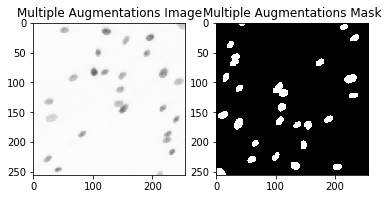

In [190]:

ix = random.randint(0, nb_aug)

plt.subplot(1,2,1)
plt.imshow(augmented[ix])
plt.title('Multiple Augmentations Image')
plt.subplot(1,2,2)
plt.imshow(augmented_mask[ix])
plt.title('Multiple Augmentations Mask')

# Types of image augmentation

83


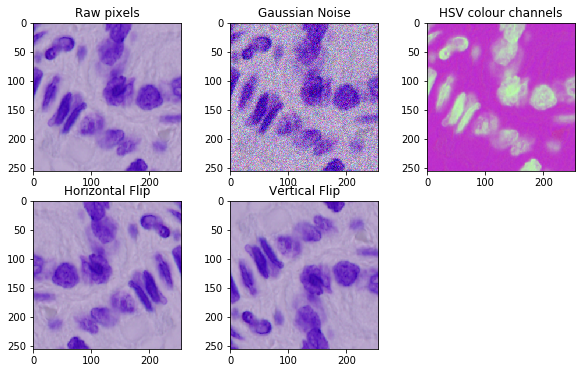

In [809]:
plt.figure(figsize = (10,6))
# ix = random.randint(0, len(X_train))
ix = 83
plt.subplot(2,3,1)
plt.imshow(X_train[ix])
plt.title('Raw pixels')
plt.subplot(2,3,2)
plt.imshow(Noisy_im[ix])
plt.title('Gaussian Noise')
plt.subplot(2,3,3)
plt.imshow(hsv_im[ix])
plt.title('HSV colour channels')
plt.subplot(2,3,4)
plt.imshow(y_axis_im[ix])
plt.title('Horizontal Flip')
plt.subplot(2,3,5)
plt.imshow(x_axis_im[ix])
plt.title('Vertical Flip')
print(ix)

In [33]:
from skimage.color import rgb2hsv

# Reload model and run on image aug

In [35]:
model_FE_imaug = load_model('model-dsbowl2018-mlp_subimage_testing2.h5', custom_objects={'mean_iou': mean_iou})

In [194]:
print(len(X_training))

670


In [34]:
# import rd
nb_aug = 670
augmented_images = np.zeros((nb_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
augmented_masks = np.zeros((nb_aug, IMG_HEIGHT, IMG_WIDTH, 1))

for index, image in enumerate(X_training):
    Image = X_training[index]
    Mask = Y_training[index]
#     for i in range(5):
# #         Image = X_train[index]
    if random.random() <0.3:
        Image = random_noise(Image)
    if random.random() <0.3:
        Image = rgb2hsv(Image)
    if random.random() <0.3:
        Image = Image[:,::-1]
        Mask = Mask[:,::-1]
    if random.random() <0.3:
        Image = Image[::-1, :]
        Mask = Mask[::-1,:]
    augmented_images[index] = Image
    augmented_masks[index] = Mask
#     counting +=1

### check things are working

Text(0.5,1,'Augmented Mask')

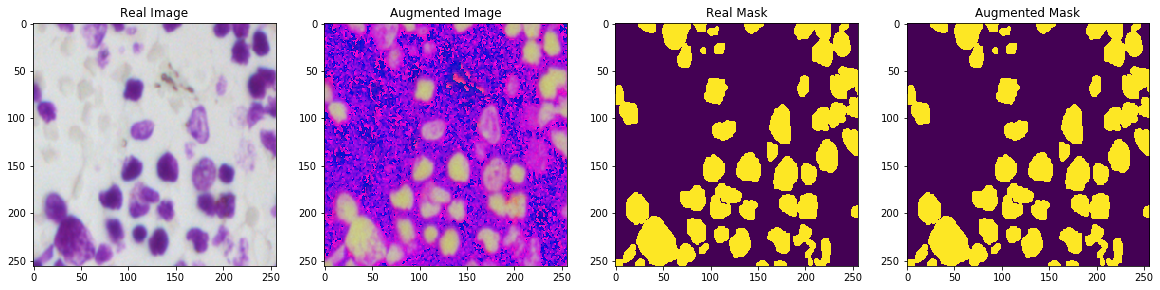

In [221]:
plt.figure(figsize= (20,20))
ix = random.randint(0, nb_aug)
plt.subplot(1,4,1)
plt.imshow(X_training[ix])
plt.title('Real Image')
plt.subplot(1,4,2)
plt.imshow(augmented_images[ix])
plt.title('Augmented Image')
plt.subplot(1,4,3)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('Real Mask')
plt.subplot(1,4,4)
plt.imshow(np.squeeze(augmented_masks[ix]))
plt.title('Augmented Mask')

In [36]:
aug_cut_im = np.zeros((len(augmented_images), 256, 16, 16, 3), dtype=np.uint8)
aug_cut_masks = np.zeros((len(augmented_images),256, 16, 16, 1), dtype = np.bool)

for index, im in enumerate(augmented_images):
    sub_augimage = np.zeros((256, 16, 16, 3), dtype = np.uint8)
    sub_augmasks = np.zeros((256, 16, 16, 1), dtype = np.bool)
    counts = 0
    for i in range(16):
        for j in range(16):
            new_augimage = augmented_images[index][16*i:16*(i+1), 16*j:16*(j+1)]
            new_augmasks = augmented_masks[index][16*i: 16*(i+1), 16*j:16*(j+1)]
            sub_augimage[counts] = new_augimage
            sub_augmasks[counts] = new_augmasks
            counts +=1
    
    aug_cut_im[index] = sub_augimage
    aug_cut_masks[index] = sub_augmasks

In [37]:
pixels_augimage = aug_cut_im.reshape(len(augmented_images),256,256,3) # image 1, first cutting (out of 256)
pixels_augmask = aug_cut_masks.reshape(len(augmented_images), 256,256,1) # 100 images, with 256 subimages that flatten so size 16*16

model_FE_imaug = load_model('model-dsbowl2018-mlp_subimage_testing2.h5', custom_objects={'mean_iou': mean_iou})
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-mlp_subimage_imaug_test_new.h5', verbose=1, save_best_only=True)
results = model_FE_imaug.fit(pixels_augimage, pixels_augmask, validation_split=0.1, batch_size=16, epochs=20,callbacks=[earlystopper, checkpointer] )

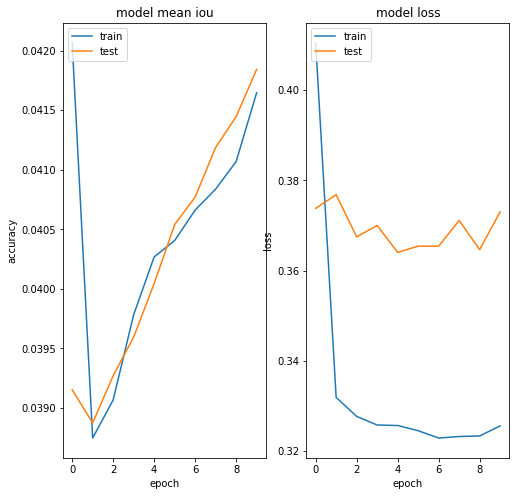

FileNotFoundError: [Errno 2] No such file or directory: 'logs.npy'

In [39]:
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['mean_iou'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['mean_iou'])
    plt.plot(history.history['val_mean_iou'])
    plt.title('model mean iou')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')
plot_learning_curve(results)
plt.show()
plotKerasLearningCurve()
plt.show()

In [40]:
model_FE2 = load_model('model-dsbowl2018-mlp_subimage_imaug_test.h5', custom_objects={'mean_iou': mean_iou})

# preds_trainFE = mFE.predict(pixels_image[:int(pixels_image.shape[0]*0.9)], verbose=1)
# preds_valFE = mlpFE.predict(pixels_im[int(pixels_im.shape[0]*0.9):], verbose=1)
preds_trainingFE2 = model_FE2.predict(pixels_image[:int(pixels_image.shape[0]*0.9)], verbose=1)
# preds_training = preds_training.reshape(603, 256, 256, 1)

preds_validFE2 = model_FE2.predict(pixels_image[int(pixels_image.shape[0]*0.9):], verbose=1)
# preds_valid = preds_valid.reshape(67, 256, 256, 1)

preds_testFE2 = model_FE2.predict(pixels_testimage, verbose=1)

65/65 [==============================] - 9s 134ms/step


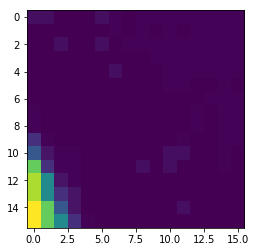

In [45]:
plt.imshow(np.squeeze(preds_trainingFE2[ix][1].reshape(16,16,1)))

In [46]:
predictive_trainingmasks_aug = []
pred_image_train_aug = np.zeros((len(preds_trainingFE2), 256, 256, 1))
for m in range(len(preds_trainingFE2)):
    reshap = []
    for image in preds_trainingFE2[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
#             print(reshap[count])
            count +=1
#     plt.imshow(np.squeeze(Final_im))        
    pred_image_train_aug[m] = Final_im

for ind, images in enumerate(pred_image_train_aug):
#     plt.imshow(np.squeeze(pred_image_train_aug[ind]))
    thresh = threshold_otsu(pred_image_train_aug[ind])
    great = np.where(pred_image_train_aug[ind]>thresh)
    less = np.where(pred_image_train_aug[ind]<thresh)
    if (sum(pred_image_train_aug[ind][great])< sum(pred_image_train_aug[ind][less])):
        pred_image_train_aug[ind][less] = 0
        pred_image_train_aug[ind][great] = 1
    else:
        pred_image_train_aug[ind][great] = 0
        pred_image_train_aug[ind][less] = 1
    predictive_trainingmasks_aug.append(pred_image_train_aug[ind])

In [48]:
pred_image_train_aug

array([[[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]]],


       [[[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        [[1.],
         [1.],
         [1.],
         ...,
         [1.],
         [1.],
         [1.]],

        ...,

        [[1.],
 

In [49]:
predictive_valmasks_aug = []
pred_image_val_aug = np.zeros((len(preds_validFE2), 256, 256, 1))
for m in range(len(preds_validFE2)):
    reshap = []
    for image in preds_validFE2[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_val_aug[m] = Final_im

for ind, images in enumerate(pred_image_val_aug):
    thresh = threshold_otsu(pred_image_val_aug[ind])
    great = np.where(pred_image_val_aug[ind]>thresh)
    less = np.where(pred_image_val_aug[ind]<thresh)
    if (sum(pred_image_val_aug[ind][great])> sum(pred_image_val_aug[ind][less])):
        pred_image_val_aug[ind][less] = 0
        pred_image_val_aug[ind][great] = 1
    else:
        pred_image_val_aug[ind][great] = 0
        pred_image_val_aug[ind][less] = 1
    predictive_valmasks_aug.append(pred_image_val_aug[ind])

In [51]:
predictive_testmasks_aug = []
pred_image_test_aug = np.zeros((len(preds_testFE2), 256, 256, 1))
for m in range(len(preds_testFE2)):
    reshap = []
    for image in preds_testFE2[m]:
        reshap.append(image.reshape(16,16,1))
    Final_im = np.zeros((256, 256, 1))
    count = 0
    for i in range(16):
        for j in range(16):
            Final_im[16*i:16*(i+1), 16*j:16*(j+1)] = reshap[count]
            count +=1
    pred_image_test_aug[m] = Final_im

for ind, images in enumerate(pred_image_test_aug):
    thresh = threshold_otsu(pred_image_test_aug[ind])
#     great = np.where(pred_image_test_aug[ind]>thresh)
#     less = np.where(pred_image_test_aug[ind]<thresh)
#     if (sum(pred_image_test_aug[ind][great])> sum(pred_image_test_aug[ind][less])):
#         pred_image_test_aug[ind][less] = 0
#         pred_image_test_aug[ind][great] = 1
#     else:
#         pred_image_test_aug[ind][great] = 0
#         pred_image_test_aug[ind][less] = 1
    predictive_testmasks_aug.append(pred_image_test_aug[ind]>thresh)

In [654]:
print(threshold_otsu(pred_image_test_aug[63]))
x = np.where(pred_image_test_aug[63]>0.46)
y = np.where(pred_image_test_aug[63]<0.46)
# print(threshold_otsu(pred_image_test_aug[64]))
# plt.imshow(np.squeeze(pred_image_test_aug[64]>0.2))
sum(pred_image_test_aug[63][y])

0.4670343429825152


3539.7173340376467

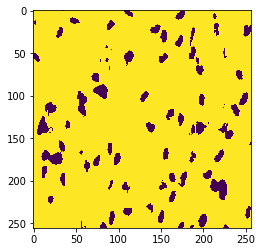

In [52]:
plt.imshow(np.squeeze(pred_image_test_aug[63]>0.46))

47


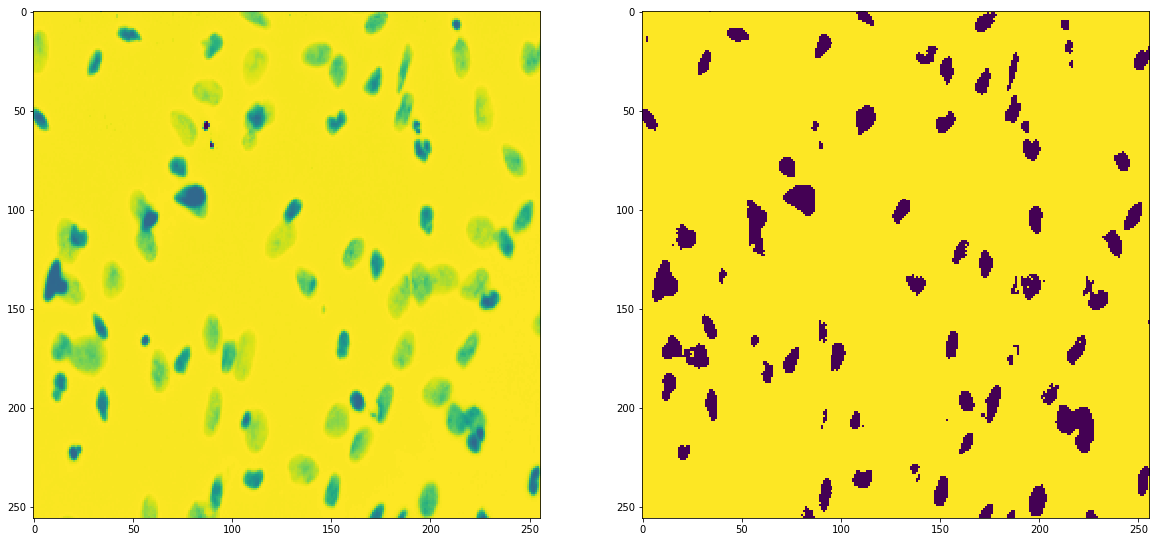

In [53]:
# print(sum(pred_image_test_aug[10][great]))
# print(sum(pred_image_test_aug[10][less]))
# print(pred_image_test_aug[10])
ix = random.randint(0, len(predictive_testmasks_aug))
print(ix)
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(np.squeeze(pred_image_test_aug[63]))

plt.subplot(1,2,2)
plt.imshow(np.squeeze(predictive_testmasks_aug[63]))
# print((pred_image_test_aug[12]-m)/s)

In [54]:
preds_test_upsampled2 = []
for i in range(len(predictive_testmasks_aug)):
    preds_test_upsampled2.append(resize(np.squeeze(predictive_testmasks_aug[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True)>0.5)

Text(0.5,1,'Predicted Mask')

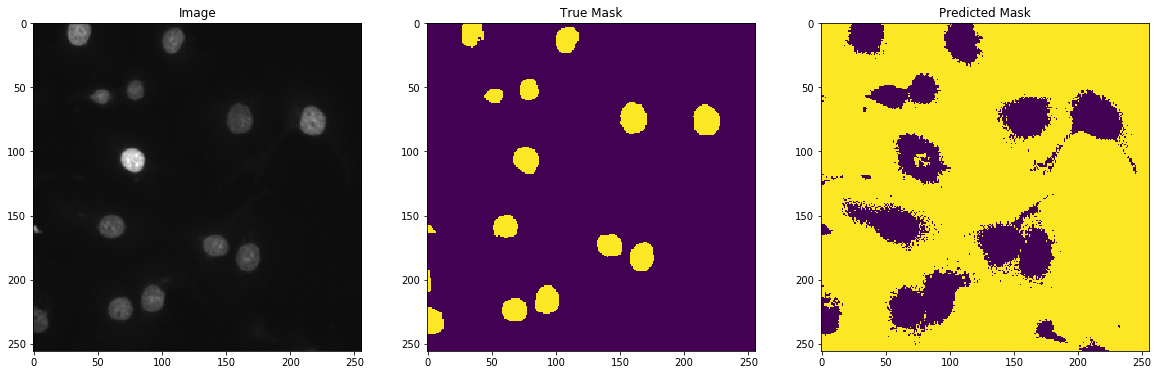

In [63]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(predictive_trainingmasks_aug))

plt.subplot(1,3,1)
plt.imshow(X_training[ix])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predictive_trainingmasks_aug[ix]))
plt.title('Predicted Mask')

Text(0.5,1,'Predicted Mask')

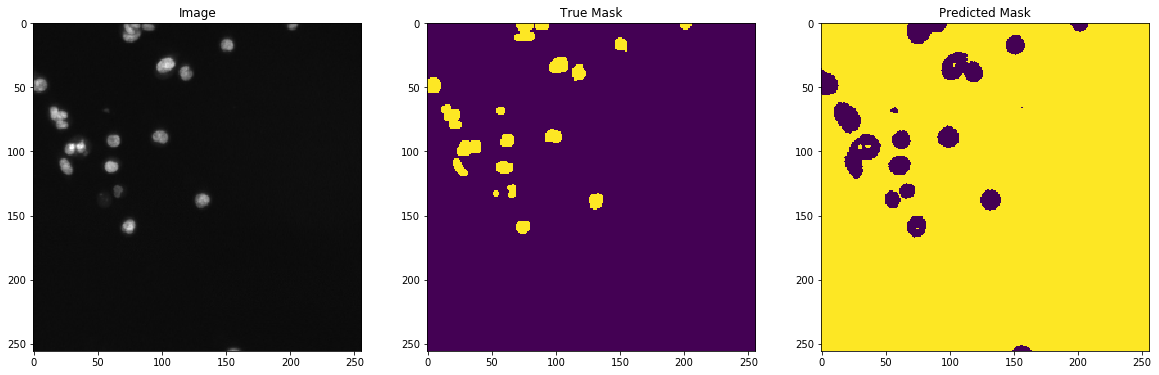

In [64]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(predictive_valmasks_aug))

plt.subplot(1,3,1)
plt.imshow(X_training[ix+603])
plt.title('Image')

plt.subplot(1,3,2)
plt.imshow(np.squeeze(Y_training[ix+603]))
plt.title('True Mask')

plt.subplot(1,3,3)
plt.imshow(np.squeeze(predictive_valmasks_aug[ix]))
plt.title('Predicted Mask')

In [14]:
plt.figure(figsize = (20,20))
ix = random.randint(0, len(preds_test_upsampled2))

plt.subplot(1,3,1)
plt.imshow(X_test[ix])
plt.title('Image')
plt.subplot(1,3,2)
plt.imshow(preds_test_upsampled[ix]<0.5)
plt.title('Predicted Mask without aug')
plt.subplot(1,3,3)
plt.imshow(preds_test_upsampled2[ix]<0.5)
plt.title('Predicted Mask with aug')
print(ix)

NameError: name 'preds_test_upsampled2' is not defined

In [81]:
new_test_ids = []
rles2 = []
for n, id_ in enumerate(testing_ids):
    rle = list(prob_to_rles(preds_test_upsampled2[n]))
    rles2.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [90]:
sub2 = pd.DataFrame()
sub2['ImageId'] = new_test_ids
sub2['EncodedPixels'] = pd.Series(rles2).apply(lambda x: ' '.join(str(y) for y in x))
sub2.to_csv('sub-dsbowl2018-mlpwithsubimage_imaug_replace_new.csv', index=False)

In [91]:
sub2

,ImageId,EncodedPixels
0,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,42555 2 43067 2
1,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,34907 2 35419 2
2,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,50367 2 50879 2
3,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,28421 2 28427 2 28433 2 28933 2 28939 2 28945 ...
4,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,53953 2 54465 2
5,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,78541 2 79053 2
6,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,33495 2 34007 2 34519 1 35029 2 35541 2 36053 ...
7,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,51417 4 51929 4 52441 3 52953 2 53465 2
8,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,32475 4 32987 4 33501 2 34013 2
9,1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c...,40159 2 40671 2


In [708]:
preds_test_upsampled2[9] = preds_test_upsampled2[9]>0.5

15


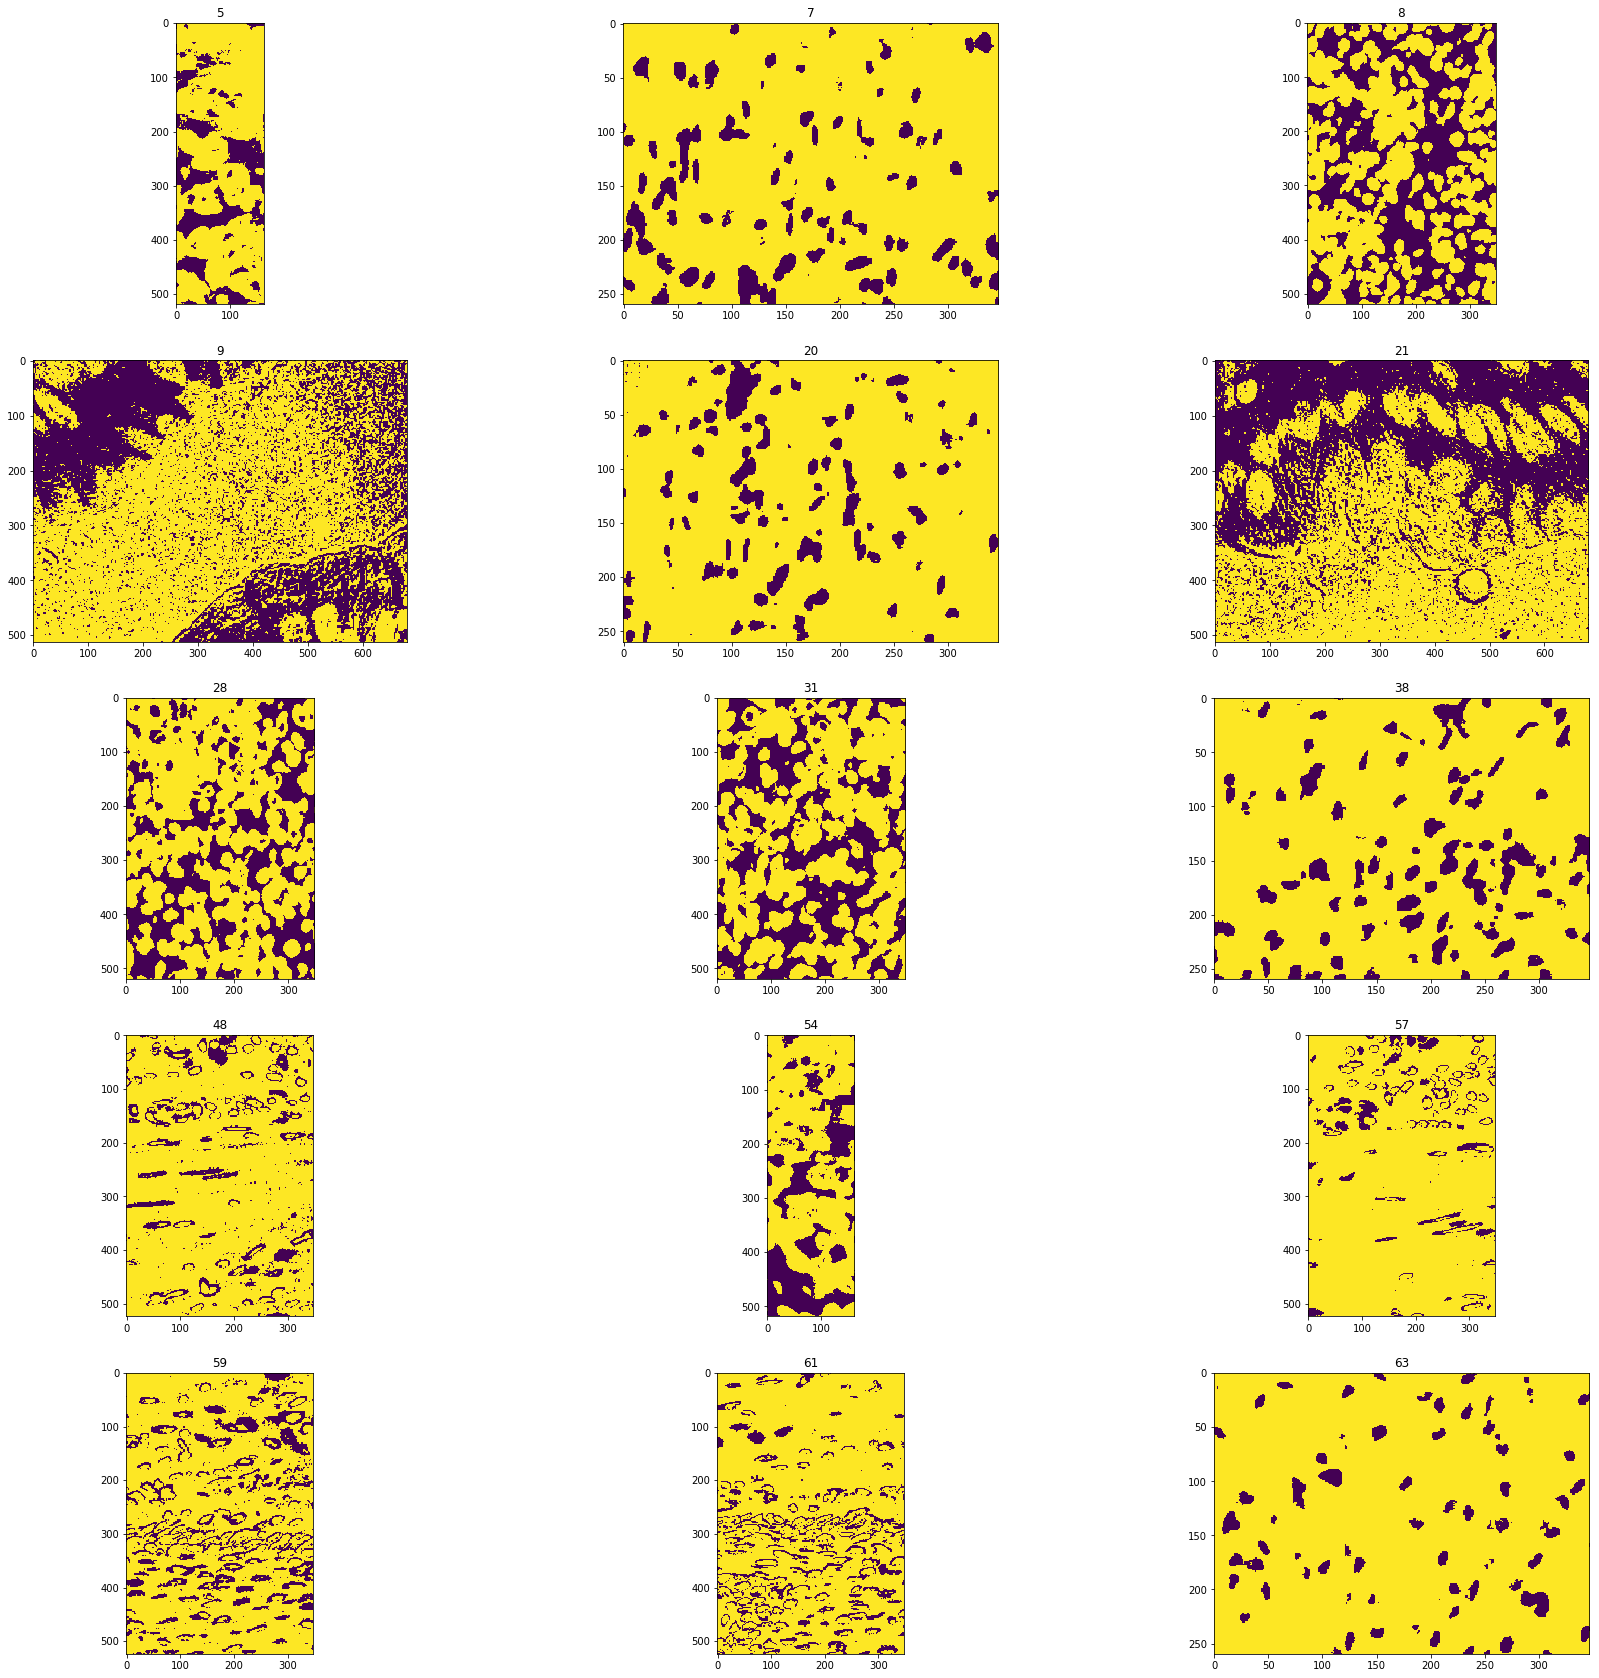

In [92]:
arr = [5, 7, 8, 9, 20, 21, 28, 31, 38, 48, 54, 57, 59, 61, 63]
print(len(arr))
plt.figure(figsize = (30,30))
count = 1
for i in arr:
    plt.subplot(5,3, count)
    plt.imshow(np.squeeze(preds_test_upsampled2[i]))
    plt.title('{}'.format(i))
    count +=1
new = [7, 20, 21, 38, 48, 59, 63]
for j in new:
    preds_test_upsampled2[j] = (preds_test_upsampled2[j]<0.5)

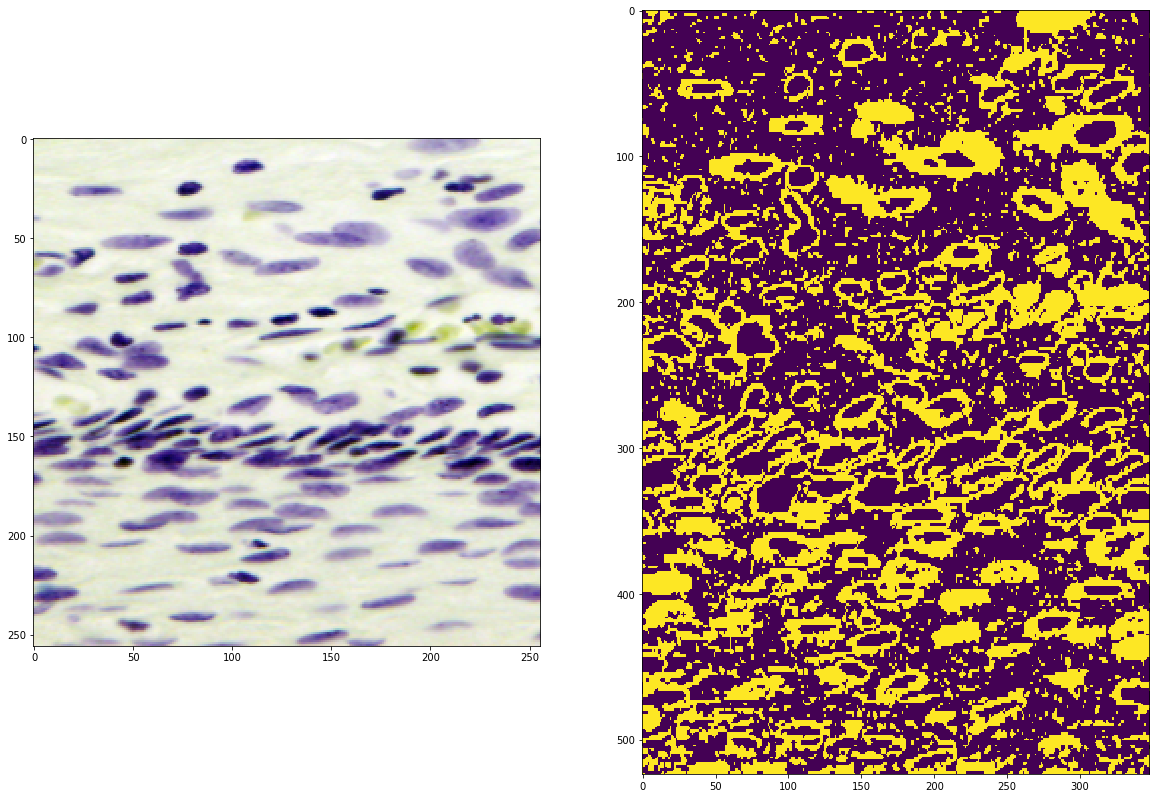

In [704]:
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(X_test[59])
plt.subplot(1,2,2)
plt.imshow(np.squeeze(preds_test_upsampled2[59]<0.5))

In [688]:
preds_test_upsampled2[arr]

TypeError: list indices must be integers or slices, not list

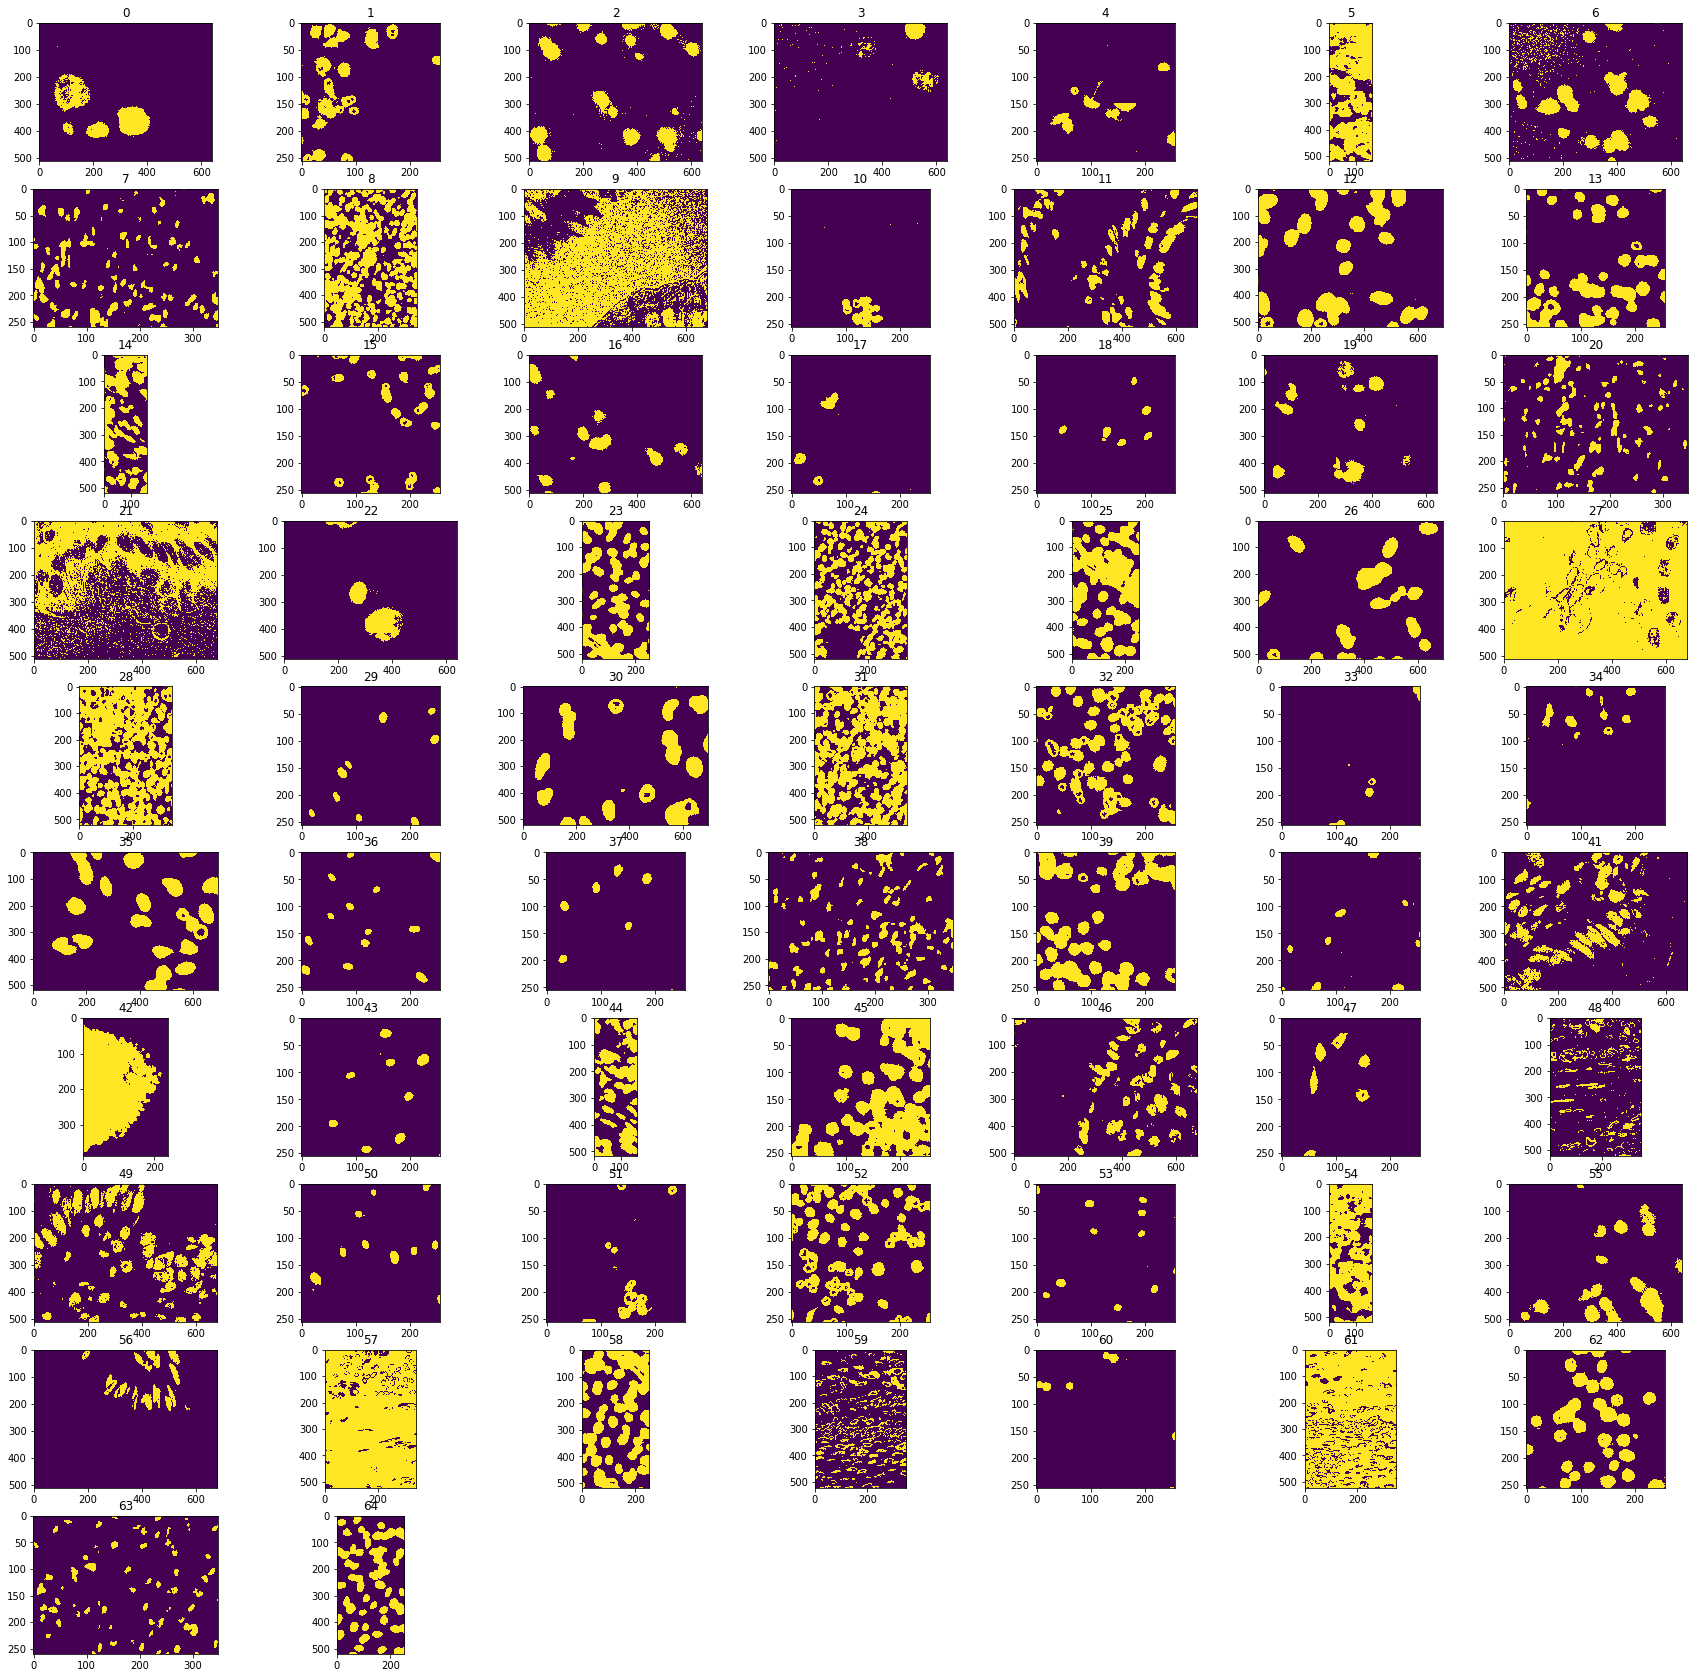

In [93]:
plt.figure(figsize=(30,30))
for i, im in enumerate(preds_test_upsampled2):
    plt.subplot(10, 7, i+1)
    plt.imshow(np.squeeze(preds_test_upsampled2[i]))
    plt.title('{}'.format(i))

In [682]:
len(preds_test_upsampled2)

65